In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import gym 
from gym import spaces
import matplotlib.patches as mpatches
from IPython.display import display
import time

In [2]:
class GridEnvironment(gym.Env):
    def __init__(self):    
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 100
        self.reward= 0
    
        #  Defining rewards, start position and goal of robot
        self.positive_rewards1 = [0, 2]
        self.positive_rewards2 = [1, 1]
        self.positive_rewards3 = [3, 1]
        self.negative_rewards1 = [1, 2]
        self.negative_rewards2 = [2, 0]
        self.negative_rewards3 = [3, 2]
        self.robot_position = [3,0]
        self.goal_position = [0,3]

        # Creating a grid of 4X4
        self.state = np.zeros((4, 4))
        self.state[tuple(self.robot_position)] = 1
        self.state[tuple(self.goal_position)] = 10
        self.state[tuple(self.positive_rewards1)] = 5
        self.state[tuple(self.positive_rewards2)] = 5
        self.state[tuple(self.positive_rewards3)] = 5
        self.state[tuple(self.negative_rewards1)] = -3
        self.state[tuple(self.negative_rewards2)] = -3
        self.state[tuple(self.negative_rewards3)] = -3

    
    def reset(self):
        self.timestep = 0
        self.robot_position = [3, 0]
        position= self.robot_position[0]*4+self.robot_position[1]
        self.goal_position = [0, 3]
        self.state = np.zeros((4, 4))
        self.state[tuple(self.robot_position)] = 1
        self.state[tuple(self.goal_position)] = 10
        self.state[tuple(self.positive_rewards1)] = 5
        self.state[tuple(self.positive_rewards2)] = 5
        self.state[tuple(self.positive_rewards3)] = 5
        self.state[tuple(self.negative_rewards1)] = -3
        self.state[tuple(self.negative_rewards2)] = -3
        self.state[tuple(self.negative_rewards3)] = -3
        self.reward = 0
        return position

    def step(self, action):
        self.state[tuple(self.robot_position)] = 0
        negative_reward_positions = [self.negative_rewards1, self.negative_rewards2, self.negative_rewards3]
        positive_reward_positions = [self.positive_rewards1, self.positive_rewards2, self.positive_rewards3]
        # If action is up
        if action == 0:
            # The robot row index is decreased by 1
            self.robot_position[0] = self.robot_position[0] - 1
            # The robot row index is less than the lower bounds, robot must stay in the same position
            if self.robot_position[0] == -1:
                self.robot_position[0] = self.robot_position[0] + 1
        # If action is down
        if action == 1:
            # The robot row index is increased by 1
            self.robot_position[0] = self.robot_position[0] + 1
            # The robot row index is greater than the upper bounds, robot must stay in the same position
            if self.robot_position[0] == 4:
                self.robot_position[0] = self.robot_position[0] - 1
        # If action is left        
        if action == 2:
            # The robot column index is decreased by 1
            self.robot_position[1] = self.robot_position[1] - 1
            # The robot column index is less than the lower bounds, robot must stay in the same position
            if self.robot_position[1] == -1:
                self.robot_position[1] = self.robot_position[1]+1
        # If action is right        
        if action == 3:
            # The robot column index is increased by 1
            self.robot_position[1] = self.robot_position[0] + 1
            # The robot column index is greater than the upper bounds, robot must stay in the same position
            if self.robot_position[1] == 4:
                self.robot_position[1] = self.robot_position[1] -1
        # limit the row and column indices of the robot's position to be between 0 and 3 (inclusive) 
        self.robot_position = np.clip(self.robot_position, 0, 3)
        state_table=np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]])
        curr = state_table[tuple(self.robot_position)]

        for value in negative_reward_positions:
            if np.array_equal(self.robot_position, value):
                self.reward = self.reward - 3
                break
        for value in positive_reward_positions:
            if np.array_equal(self.robot_position, value):
                self.reward = self.reward + 5
                break
                
        goalFlag = False
        if np.array_equal(self.robot_position, self.goal_position):
            self.reward = self.reward + 10
            goalFlag = True
            
        self.state[tuple(self.robot_position)] = 1
        self.state[tuple(self.positive_rewards1)] = 5
        self.state[tuple(self.positive_rewards2)] = 5
        self.state[tuple(self.positive_rewards3)] = 5
        self.state[tuple(self.negative_rewards1)] = -3
        self.state[tuple(self.negative_rewards2)] = -3
        self.state[tuple(self.negative_rewards3)] = -3

        self.timestep = self.timestep + 1
        if (self.timestep >= self.max_timesteps or goalFlag):
            done = True
        else:
            done = False
        return curr, self.reward, done

    def render(self):
        time.sleep(0.01)
        return plt.imshow(self.state)

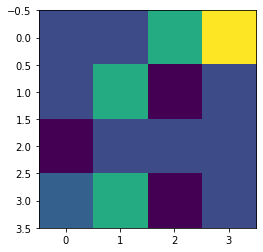

In [3]:
environment = GridEnvironment()
observation = environment.reset()
environment.render()

In [4]:
def q_learning(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix):
    epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix = epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix
    # Starting the Q-learning
    all_rewards, all_epsilons = [], []
    reward, max_reward, average = 0, 0, 0

    for episode in range(number_of_episodes):
        step = 0
        state = environment.reset()

        while step < max_steps:
            environment.render()
            if np.random.uniform(0, 1) < epsilon:
                action = environment.action_space.sample()
            else:
                action = np.argmax(Q_matrix[state, :])

            next_state, reward, done = environment.step(action)

            # Update Q-value
            predict = Q_matrix[state, action]
            target = reward + discount * np.max(Q_matrix[next_state, :])
            Q_matrix[state, action] = Q_matrix[state, action] + lr_rate * (target - predict)

            state = next_state

            if epsilon > 0.1:
                epsilon = epsilon - epsilon_decay_rate

            step = step + 1

            if done:
                all_epsilons.append(epsilon)
                all_rewards.append(reward)
                break

        if reward > max_reward:
            max_reward = reward
        print(f'Episode Number: {episode}, Reward: {reward}, Epsilon: {epsilon}')

    print(f'Max Reward: {max_reward}')
    print(f'Performance: {reward/number_of_episodes}')
    print(Q_matrix)

    return all_epsilons, all_rewards


def reward_plot(reward_values):
    figure, axes = plt.subplots()  # Creates a figure object and an axes object
    axes.plot(reward_values, label='Rewards Graph')  # Plotting the epsilon values
    axes.set_xlabel('Rewards')  
    axes.set_ylabel('Epsilon')  
    axes.legend()               
    plt.show()    

def epsilon_plot(epsilon_values):
    figure, axes = plt.subplots()  # Creates a figure object and an axes object
    axes.plot(epsilon_values, label='Epsilon Graph')  # Plotting the epsilon values
    axes.set_xlabel('Episode')  # x-axis label
    axes.set_ylabel('Epsilon')  # y-axis label
    axes.legend()               
    plt.show()                  


Episode Number: 0, Reward: 19, Epsilon: 0.7999999999999999
Episode Number: 1, Reward: -21, Epsilon: 0.6999999999999998
Episode Number: 2, Reward: -15, Epsilon: 0.6359999999999998
Episode Number: 3, Reward: 87, Epsilon: 0.5359999999999997
Episode Number: 4, Reward: 83, Epsilon: 0.4359999999999996
Episode Number: 5, Reward: 32, Epsilon: 0.3359999999999995
Episode Number: 6, Reward: 113, Epsilon: 0.23599999999999943
Episode Number: 7, Reward: 306, Epsilon: 0.13599999999999934
Episode Number: 8, Reward: 234, Epsilon: 0.09999999999999931
Episode Number: 9, Reward: 92, Epsilon: 0.09999999999999931
Episode Number: 10, Reward: 100, Epsilon: 0.09999999999999931
Episode Number: 11, Reward: 67, Epsilon: 0.09999999999999931
Episode Number: 12, Reward: 10, Epsilon: 0.09999999999999931
Episode Number: 13, Reward: 38, Epsilon: 0.09999999999999931
Episode Number: 14, Reward: 26, Epsilon: 0.09999999999999931
Episode Number: 15, Reward: 93, Epsilon: 0.09999999999999931
Episode Number: 16, Reward: 172, E

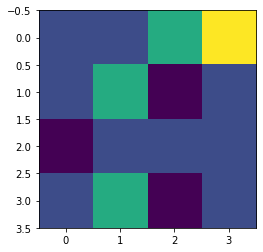

In [5]:
#Defining the different parameters
epsilon = 0.9
# min_epsilon = 0.1
# max_epsilon = 1.0
epsilon_decay_rate = 0.001
number_of_episodes = 100
max_steps = 100
lr_rate = 0.85             # learning rate or alpha
discount = 0.95            # Discount factor or gamma
# print(environment.observation_space)
# print(environment.observation_space.n)
Q_matrix = np.zeros((environment.observation_space.n, environment.action_space.n)) #Initialize the Q-matrix
epsilon_q_learning1, reward_q_learning1 = q_learning(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix)

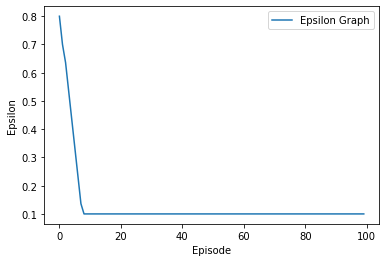

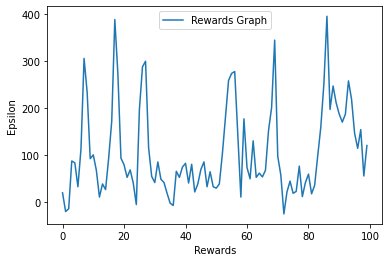

In [6]:
epsilon_plot(epsilon_q_learning1)
reward_plot(reward_q_learning1)

**Hyper parameter tuning**

In [7]:
#Defining the different parameters
epsilon = 0.7
# min_epsilon = 0.1
# max_epsilon = 1.0
epsilon_decay_rate = 0.01
number_of_episodes = 200
max_steps = 100
lr_rate = 0.85             # learning rate or alpha
discount = 0.95            # Discount factor or gamma
# print(environment.observation_space)
# print(environment.observation_space.n)
Q_matrix = np.zeros((environment.observation_space.n, environment.action_space.n)) #Initialize the Q-matrix
epsilon_q_learning2, reward_q_learning2 = q_learning(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix)


Episode Number: 0, Reward: 35, Epsilon: 0.09999999999999946
Episode Number: 1, Reward: -1, Epsilon: 0.09999999999999946
Episode Number: 2, Reward: 30, Epsilon: 0.09999999999999946
Episode Number: 3, Reward: 197, Epsilon: 0.09999999999999946
Episode Number: 4, Reward: 32, Epsilon: 0.09999999999999946
Episode Number: 5, Reward: 144, Epsilon: 0.09999999999999946
Episode Number: 6, Reward: 34, Epsilon: 0.09999999999999946
Episode Number: 7, Reward: 57, Epsilon: 0.09999999999999946
Episode Number: 8, Reward: 9, Epsilon: 0.09999999999999946
Episode Number: 9, Reward: 20, Epsilon: 0.09999999999999946
Episode Number: 10, Reward: 5, Epsilon: 0.09999999999999946
Episode Number: 11, Reward: 117, Epsilon: 0.09999999999999946
Episode Number: 12, Reward: 4, Epsilon: 0.09999999999999946
Episode Number: 13, Reward: -15, Epsilon: 0.09999999999999946
Episode Number: 14, Reward: 3, Epsilon: 0.09999999999999946
Episode Number: 15, Reward: -24, Epsilon: 0.09999999999999946
Episode Number: 16, Reward: 186, 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Kedar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-92d042e1756d>", line 13, in <module>
    epsilon1, reward_q_learning2 = q_learning(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix)
  File "<ipython-input-4-88730c0dbbba>", line 12, in q_learning
    environment.render()
  File "<ipython-input-2-d717da08bf5e>", line 114, in render
    time.sleep(0.01)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Kedar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x000001F9153DE700> (for post_execute):


KeyboardInterrupt: 

In [ ]:
epsilon_plot(epsilon_q_learning2)
reward_plot(reward_q_learning2)

In [ ]:
#Defining the different parameters
epsilon = 0.5
# min_epsilon = 0.1
# max_epsilon = 1.0
epsilon_decay_rate = 0.001
number_of_episodes = 225
max_steps = 100
lr_rate = 0.75             # learning rate or alpha
discount = 0.85            # Discount factor or gamma
# print(environment.observation_space)
# print(environment.observation_space.n)
Q_matrix = np.zeros((environment.observation_space.n, environment.action_space.n)) #Initialize the Q-matrix
epsilon_q_learning3, reward_q_learning3 = q_learning(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix)


In [ ]:
epsilon_plot(epsilon_q_learning3)
reward_plot(reward_q_learning3)

In [ ]:
#Defining the different parameters
epsilon = 0.8
# min_epsilon = 0.1
# max_epsilon = 1.0
epsilon_decay_rate = 0.1
number_of_episodes = 250
max_steps = 100
lr_rate = 0.85             # learning rate or alpha
discount = 0.95            # Discount factor or gamma
# print(environment.observation_space)
# print(environment.observation_space.n)
Q_matrix = np.zeros((environment.observation_space.n, environment.action_space.n)) #Initialize the Q-matrix
epsilon_q_learning4, reward_q_learning4 = q_learning(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix)


In [ ]:
epsilon_plot(epsilon_q_learning4)
reward_plot(reward_q_learning4)

In [ ]:
#Defining the different parameters
epsilon = 0.2
# min_epsilon = 0.1
# max_epsilon = 1.0
epsilon_decay_rate = 0.009
number_of_episodes = 275
max_steps = 100
lr_rate = 0.8             # learning rate or alpha
discount = 0.7            # Discount factor or gamma
# print(environment.observation_space)
# print(environment.observation_space.n)
Q_matrix = np.zeros((environment.observation_space.n, environment.action_space.n)) #Initialize the Q-matrix
epsilon_q_learning5, reward_q_learning5 = q_learning(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix)


In [ ]:
epsilon_plot(epsilon_q_learning5)
reward_plot(reward_q_learning5)

In [ ]:
#Defining the different parameters
epsilon = 0.3
# min_epsilon = 0.1
# max_epsilon = 1.0
epsilon_decay_rate = 0.05
number_of_episodes = 300
max_steps = 100
lr_rate = 0.5             # learning rate or alpha
discount = 0.5            # Discount factor or gamma
# print(environment.observation_space)
# print(environment.observation_space.n)
Q_matrix = np.zeros((environment.observation_space.n, environment.action_space.n)) #Initialize the Q-matrix
epsilon_q_learning6, reward_q_learning6 = q_learning(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix)


In [ ]:
epsilon_plot(epsilon_q_learning6)
reward_plot(reward_q_learning6)

**Bonus task
n-step SARSA [5 points]
Modify your SARSA and implement a 2-step bootstrapping SARSA. Compare the results with SARSA.**

In [ ]:
import numpy as np
import gym
environment = GridEnvironment()
observation = environment.reset()
environment.render()

In [ ]:
def sarsa_bootstrap(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix):
    epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix = epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix
    # Starting the SARSA learning
    all_rewards, all_epsilons = [], []
    reward, max_reward, average = 0, 0, 0
    for episode in range(number_of_episodes):
        step = 0
        state1 = environment.reset()
        # Action
        action1 = 0
        if np.random.uniform(0, 1) < epsilon:
            action1 = environment.action_space.sample()
        else:
            action1 = np.argmax(Q_matrix[state1, :])
        while step < max_steps:
            environment.render()
            state2, reward, done = environment.step(action1)

            # Next Action
            action2 = 0
            if np.random.uniform(0, 1) < epsilon:
                action2 = environment.action_space.sample()
            else:
                action2 = np.argmax(Q_matrix[state2, :])

            # Next Action
            action3 = 0
            if np.random.uniform(0, 1) < epsilon:
                action3 = environment.action_space.sample()
            else:
                action3 = np.argmax(Q_matrix[state2, :])

            # Learning Q-value
            predict = Q_matrix[state1, action1]
            target = reward + discount * (Q_matrix[state2, action2] + discount * Q_matrix[state2, action3])
            Q_matrix[state1, action1] = Q_matrix[state1, action1] + lr_rate * (target - predict)
            state1 = state2
            action1 = action2

            if epsilon > 0.1:
                epsilon = epsilon - epsilon_decay_rate

            # Updating the respective values
            step = step + 1
            reward = reward + 1

            # If at the end of learning process
            if done:
                all_epsilons.append(epsilon)
                all_rewards.append(reward)  # Add the episode reward to the list
                break
                
        if reward > max_reward:
            max_reward = reward
        print(f'Episode Number : {episode}, Reward : {reward}, Epsilon : {epsilon}')
    print(f'Max Reward : {max_reward}')
    print(f'Performance : {reward/number_of_episodes}')
    print(Q_matrix)
    return all_epsilons, all_rewards


In [ ]:
#Defining the different parameters
epsilon = 0.9
# min_epsilon = 0.1
# max_epsilon = 1.0
epsilon_decay_rate = 0.001
number_of_episodes = 100
max_steps = 100
lr_rate = 0.85             # learning rate or alpha
discount = 0.95            # Discount factor or gamma
# print(environment.observation_space)
# print(environment.observation_space.n)
Q_matrix = np.zeros((environment.observation_space.n, environment.action_space.n)) #Initialize the Q-matrix
epsilon_sarsa_2boot1, rewards_sarsa_2boot1 = sarsa_bootstrap(epsilon, epsilon_decay_rate, number_of_episodes, max_steps, lr_rate, discount, Q_matrix)

In [ ]:
epsilon_plot(epsilon_sarsa_2boot1)
reward_plot(rewards_sarsa_2boot1)